# Можем ли мы заработать с помощью анализа новостей о компаниях? (Ответ: почти)
Предсказать сколько будет стоить та или иная бумага наперед невозможно, так как стоимость зависит от постоянно поступающей информации.
Однако, мы можем попытаться выделить определенные тренды связанные с восприятием компании обществом. И на основе их делать наши ставки (цена акции поднимется в ближайшем будущем). Тренды как раз таки устойчивы во времени. И мы анализируем не цену акции во времени, а общее мнение о компании во времени. 

Мы, с силу ограничений api, будем смотреть новости за первые 15 дней, оценивать насколько они положительны, предполагать, что мы инвестируем если новости положительные, шортим, если новости отрицательные, а потом смотрим как рынок сыграет за оставшиеся 15 дней.


![alt text](https://images.unsplash.com/photo-1549488799-496ecb87b5b3?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=900&q=60)

In [1]:
import pandas as pd 
import numpy as np
import requests
from bs4 import BeautifulSoup



## Парсим новости
из открытых источников

Достаем новости с помощью api

In [205]:
def getnewsabout(company,ondate="2019-04-10"):
    url = " https://newsapi.org/v2/everything?q="+company+"&from="+ondate+"&to="+ondate+"&sortBy=popularity&apiKey=48a276e66a4f4c51a886044af732a66a"
    params = {
        'format': 'json'
            }

    r = requests.get(url, params=params)
    q = r.json()
    #return q['articles'][1]['title']
    return q['articles']
    #return q



### К примеру вот так выглядят новости о компании Ford

In [3]:
ford=getnewsabout("Ford","2019-04-09")
len(ford)

20

Как мы видим о компании написали 20 раз в эту дату. 

In [4]:
fordpd= pd.DataFrame(columns=['date','author', 'title', 'description', 'publishedAt','content' ])
len(ford)

20

In [5]:
for i in range(0,len(ford)):
    fordpd.loc[-i] = ["2019-04-09", ford[i]['author'],ford[i]['title'],ford[i]['description'],ford[i]['publishedAt'],ford[i]['content']]


In [6]:
fordpd= fordpd.reset_index( drop=True)

# Достаем данные о стоимости акции и их приросте

In [187]:
def getstockdifference(company="msft"):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+company+"&apikey=MKHYA7R2V7PUK5OR"
    params = {
        'format': 'json'
            }

    r = requests.get(url, params=params)
    q = r.json()
    b=float(q['Time Series (Daily)']['2019-04-12']['4. close'])
    a=float(q['Time Series (Daily)']['2019-03-29']['4. close'])
    return (b-a)/a
    


## Обрабатываем новости на положительные и отрицательные (машинное обучение и вейдер)


![alt text](https://images.unsplash.com/photo-1504711434969-e33886168f5c?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=900&q=60)

In [12]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Kirill/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
a="VADER is a normal person!"
vs = analyzer.polarity_scores(a)
vs['compound']

0.0

In [14]:
fordpd

,date,author,title,description,publishedAt,content
0,2019-04-09,Kirsten Korosec,Voyage CEO Oliver Cameron at TC Sessions: Mobi...,Some of the first users of autonomous taxis ar...,2019-04-09T16:34:00Z,Some of the first users of autonomous taxis ar...
1,2019-04-09,Chris Paukert,2020 Hyundai Venue gets sketched out ahead of ...,Hyundai's lineup is about to add one of the in...,2019-04-09T12:37:42Z,After years of nursing an undernourished SUV l...
2,2019-04-09,msmash,Ford and University of Michigan Study Whether ...,Ford and the University of Michigan undertook ...,2019-04-09T22:15:00Z,Flying cars make sense to me as point to point...
3,2019-04-09,Dhruv.A,Hyundai Venue To Get 8-inch Infotainment Syste...,Will be the first car in its segment to get in...,2019-04-09T10:07:00Z,Debuts Blue Link telematics and internet-based...
4,2019-04-09,Surendhar M,Hyundai Releases Design Sketch Of Upcoming Ven...,Hyundai Releases Design Sketch Of Upcoming Ven...,2019-04-09T03:14:00Z,Hyundai has a slew of new products lined up fo...
5,2019-04-09,Katie DeRosa,"B.C. government to ban scalper bots, set new r...","B.C. government to ban scalper bots, set new r...",2019-04-09T18:14:00Z,"Scalper bots, which allow ticket resellers to ..."
6,2019-04-09,None,"In Aberdeen, Brexit is a storm of bad news – b...","In Aberdeen, Brexit is a storm of bad news – b...",2019-04-09T15:17:38Z,"The busy harbour of Aberdeen, Scotland's third..."
7,2019-04-09,Mark Frauenfelder,No food on weekends and ice-cold baths: Twitte...,Twitter and Square CEO Jack Dorsey (42) walks ...,2019-04-09T18:34:15Z,Twitter and Square CEO Jack Dorsey (42) walks ...
8,2019-04-09,probertoj,33 maneras diferentes de ser un hacker (según ...,A los hackers se les ha hecho caso en el cine ...,2019-04-09T10:01:22Z,A los hackers se les ha hecho caso en el cine ...
9,2019-04-09,"AP, AP, AP",Ford CEO says he wants stability on tariffs,Ford CEO Jim Hackett says he is hoping for bal...,2019-04-09T18:55:25Z,None


Так выглядят новости для анализа

In [15]:
analyzer.polarity_scores(fordpd['content'][3])

{'neg': 0.167, 'neu': 0.675, 'pos': 0.158, 'compound': -0.1027}

In [16]:
score_descr=[]
score_content=[]
score_title=[]
for i in range(0,fordpd.shape[0]):
    vs=analyzer.polarity_scores(fordpd['description'][i])
    score_descr.append(vs['compound'])
    vs=analyzer.polarity_scores(str(fordpd['content'][i]))
    score_content.append(vs['compound'])
    vs=analyzer.polarity_scores(fordpd['title'][i])
    score_title.append(vs['compound'])
print(np.mean(score_content), np.var(score_content))
print(np.mean(score_title), np.var(score_title))
print(np.mean(score_descr),np.var(score_descr))

0.13555 0.12207400049999999
-0.051505 0.06691646947499999
0.099725 0.178890224875


In [322]:
df['date']=pd.date_range(start='14/03/2019', end='14/04/2019')

In [365]:
import datetime 
date_string = df['date'][0].strftime('%Y-%m-%d')
print("Ford")


Ford


### Делаем красивую функцию которая будет считать нам все про компанию
мы будем брать медиану при оценке новостей за день, так как мы хотим быть устойчивыми к слишком радостной или депрессивной прессе. (Избежать тяжелых хвостов, которые дадут баес)

In [17]:
def get_sensitivity(comp="Ford"):
    df=pd.DataFrame(columns=['date','mean_title', 'var_title', 'mean_description', 'var_description','mean_content','var_content' ])
    df['date']=pd.date_range(start='15/03/2019', end='29/03/2019')
    score_descr=[]
    score_content=[]
    score_title=[]
    for i in range(0,df.shape[0]):
        date_string = df['date'][i].strftime('%Y-%m-%d')
        fd=getnewsabout(comp,date_string)
        fordpd= pd.DataFrame(columns=['date','author', 'title', 'description', 'publishedAt','content' ])
        for x in range(0,len(fd)):
            fordpd.loc[-x] = [date_string, fd[x]['author'],fd[x]['title'],fd[x]['description'],fd[x]['publishedAt'],fd[x]['content']]
        fordpd= fordpd.reset_index( drop=True)
        for j in range(0,fordpd.shape[0]):
            vs=analyzer.polarity_scores(str(fordpd['description'][j]))
            score_descr.append(vs['compound'])
            vs=analyzer.polarity_scores(str(fordpd['content'][j]))
            score_content.append(vs['compound'])
            vs=analyzer.polarity_scores(str(fordpd['title'][j]))
            score_title.append(vs['compound'])
        df['mean_title'][i]=np.median(score_title)
        df['var_title'][i]=np.var(score_title)
        df['mean_description'][i]=np.median(score_descr)
        df['var_description'][i]=np.var(score_descr)
        df['mean_content'][i]=np.median(score_content)
        df['var_content'][i]=np.var(score_content) 
    return df

In [18]:
fordstock=get_sensitivity()

In [19]:
fordstock

,date,mean_title,var_title,mean_description,var_description,mean_content,var_content
0,2019-03-15,0,0.0774814,0.2481,0.227035,0.2957,0.165631
1,2019-03-16,0,0.0873419,0,0.216976,0.05135,0.202868
2,2019-03-17,0,0.0830568,0,0.219241,0.106,0.224933
3,2019-03-18,0,0.0931193,0,0.218972,0.08995,0.209886
4,2019-03-19,0,0.0908929,0,0.200934,0.0644,0.20905
5,2019-03-20,0,0.0966994,0,0.192117,0.08995,0.20305
6,2019-03-21,0,0.105675,0,0.197006,0.1436,0.201878
7,2019-03-22,0,0.109017,0,0.211596,0.20835,0.200222
8,2019-03-23,0,0.109569,0,0.21255,0.184,0.202277
9,2019-03-24,0,0.109398,0,0.210803,0.184,0.223153


In [210]:
import matplotlib.pyplot as plt
%matplotlib inline

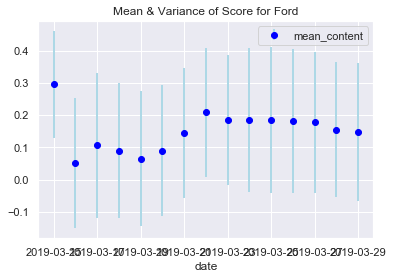

In [232]:
plt.errorbar('date', 'mean_content', yerr='var_content', fmt='o', color='blue',
             ecolor='lightblue', elinewidth=2, capsize=0, data=fordstock);
plt.title("Mean & Variance of Score for Ford")
plt.xlabel("date")
plt.legend();

In [234]:
tsla=get_sensitivity("Tesla")

In [235]:
tsla

,date,mean_title,var_title,mean_description,var_description,mean_content,var_content
0,2019-03-15,0,0.11396,0.2957,0.168856,0,0.177736
1,2019-03-16,0,0.104091,0.0386,0.144519,0,0.183449
2,2019-03-17,0,0.0924123,0,0.135851,0,0.193643
3,2019-03-18,0,0.102077,0,0.180006,0,0.215938
4,2019-03-19,0,0.121122,0,0.209084,0,0.21235
5,2019-03-20,0,0.106028,0,0.209132,0,0.21562
6,2019-03-21,0,0.105465,0,0.21673,0,0.219381
7,2019-03-22,0,0.101213,0,0.210971,0,0.21479
8,2019-03-23,0,0.0975409,0,0.205222,0,0.208856
9,2019-03-24,0,0.0917617,0,0.202265,0,0.21309


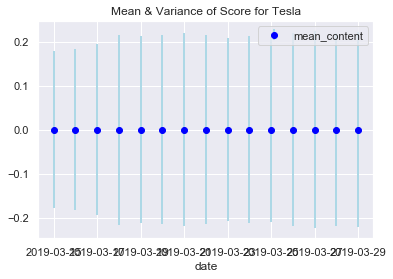

In [236]:
plt.errorbar('date', 'mean_content', yerr='var_content', fmt='o', color='blue',
             ecolor='lightblue', elinewidth=2, capsize=0, data=tsla);
plt.title("Mean & Variance of Score for Tesla")
plt.xlabel("date")
plt.legend();

In [237]:
microsoft=get_sensitivity("Microsoft")

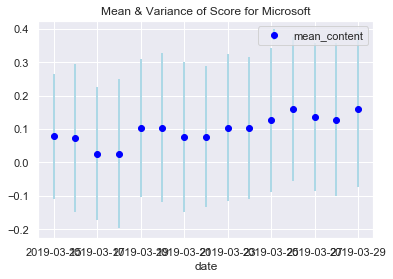

In [238]:
plt.errorbar('date', 'mean_content', yerr='var_content', fmt='o', color='blue',
             ecolor='lightblue', elinewidth=2, capsize=0, data=microsoft);
plt.title("Mean & Variance of Score for Microsoft")
plt.xlabel("date")
plt.legend();

In [399]:
microsoft['mean_content'].mean()

0.13539218750000004

Это значит что средняя медиана новостей про Microsoft положительная.

## Проверяем нашу стратегию (BackTesting)

In [202]:
listofcomp=["Omnicell",
"Apple",
"Mattel",
"Marriott","eBay"]
#"eBay","Amazon","Blizzard","Erytech","Littelfuse","Adidas","Tesco"]

In [203]:
len(listofcomp)

5

In [206]:
results=[]
for i in range(0,len(listofcomp)):
    results.append(get_sensitivity(listofcomp[i])['mean_content'].mean())
print(results)

[0.5207307692307692, 0.2684166666666667, 0.2598033333333334, 0.3817566666666667, 0.0]


In [239]:
listandcoefs=pd.DataFrame({'Name' : listofcomp, 'Coef' : results})    

In [240]:
listandcoefs

,Name,Coef
0,Omnicell,0.520731
1,Apple,0.268417
2,Mattel,0.259803
3,Marriott,0.381757
4,eBay,0.000000


Как мы видим, первые 4 стока нам стоит купить!

In [188]:
listoftik=["AVN",
"OMCL",
"AAPL",
"MAT",
"MAR"]
#"EBAYL","AMZN","ATVI","ERYP","LFUS","ADS","TSCO"]

In [191]:
getstockdifference("OMCL")

0.010761999010390776

In [192]:
getstockdifference("AAPL")

0.04695972624374844

In [193]:
getstockdifference("MAT")

0.04615384615384613

In [194]:
getstockdifference("MAR")

0.07642497401870654

In [195]:
getstockdifference("EBAYL")

-0.011043412033511146

In [242]:
np.mean([0.07642497401870654,0.04615384615384613,0.04695972624374844,0.010761999010390776])

0.04507513635667297

# Смотрите, наш анализ работает за 15 дней мы заработали в среднем 4.5% !!!

In [196]:
getstockdifference("ATVI")

0.038436195914781465

In [197]:
getstockdifference("ERYP")

-0.0013192612137202884

In [198]:
getstockdifference("LFUS")

0.07885795703638764

# Как мы можем проверить нашу стратегию?
Мы можем брать случайные сэмплы и смотреть на то, что об этим команиях предсказал наш анализ новостей, а потом сравнивать с тем как отыграл рынок.
Далее код и рассуждения при наличии платного API

## Вот так мы можем достать данные симпатичнее, но наткнемся на то, что количество запросов ограничено. 
### Единственный способ сделать наш анализ во времени симпатичнее это купить платный api...

In [189]:
tikres=[]
for i in range(0,len(listoftik)):
    tikres.append(getstockdifference(listoftik[i]))
print(tikres)

KeyError: '2019-04-12'

In [33]:
complist=pd.read_csv("companylist.csv")

In [106]:
complist.sample(30)

,Symbol,Name,LastSale,MarketCap,IPOyear,Sector,industry,Summary Quote,Unnamed: 8
1661,INTU,Intuit Inc.,260.0600,$67.37B,1993.0,Technology,Computer Software: Prepackaged Software,https://www.nasdaq.com/symbol/intu,NaN
1086,FNHC,FedNat Holding Company,16.9300,$216.44M,NaN,Finance,Property-Casualty Insurers,https://www.nasdaq.com/symbol/fnhc,NaN
2586,PMD,Psychemedics Corporation,14.4800,$79.75M,NaN,Health Care,Medical Specialities,https://www.nasdaq.com/symbol/pmd,NaN
753,CNMD,CONMED Corporation,83.1800,$2.34B,1987.0,Health Care,Biotechnology: Electromedical & Electrotherape...,https://www.nasdaq.com/symbol/cnmd,NaN
2383,ORRF,Orrstown Financial Services Inc,19.1900,$181.96M,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/orrf,NaN
3306,CFA,VictoryShares US 500 Volatility Wtd ETF,51.7813,$714.56M,NaN,NaN,NaN,https://www.nasdaq.com/symbol/cfa,NaN
2398,OVID,Ovid Therapeutics Inc.,1.8300,$70.73M,2017.0,Health Care,Major Pharmaceuticals,https://www.nasdaq.com/symbol/ovid,NaN
3450,ZIONW,Zions Bancorporation N.A.,15.9900,NaN,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/zionw,NaN
2333,ODFL,"Old Dominion Freight Line, Inc.",153.7400,$12.48B,1991.0,Transportation,Trucking Freight/Courier Services,https://www.nasdaq.com/symbol/odfl,NaN
3166,PRTS,"U.S. Auto Parts Network, Inc.",1.0300,$36.47M,2007.0,Consumer Services,Other Specialty Stores,https://www.nasdaq.com/symbol/prts,NaN


С источниками новостей, конечно, беда. Все новостные сайты стараются сделать это как можно более сложной задачей. 
Но на насдаке новости можно выкачать с помощью BeautifulSoup!
Как скачивать с насдака придумали до меня. 
Ниже код не мой! 
Взят отсюда http://theautomatic.net/2017/08/24/scraping-articles-about-stocks/

In [269]:
### FROM: http://theautomatic.net/2017/08/24/scraping-articles-about-stocks/
from bs4 import BeautifulSoup
 
site = 'http://www.nasdaq.com/symbol/nflx/news-headlines'

In [245]:
'''scrape the html of the site'''
html = requests.get(site).content
 
'''convert html to BeautifulSoup object'''
soup = BeautifulSoup(html , 'lxml')
 
'''get list of all links on webpage'''
links = soup.find_all('a')
 
urls = [link.get('href') for link in links]
urls = [url for url in urls if url is not None]
 
len(urls)

216

In [246]:
'''Filter the list of urls to just the news articles'''
news_urls = [url for url in urls if '/article/' in url]
 
len(news_urls)

16

In [250]:
'''Package what we did above into a function'''
def scrape_news_text(news_url):
 
    news_html = requests.get(news_url).content
 
    '''convert html to BeautifulSoup object'''
    news_soup = BeautifulSoup(news_html , 'lxml')
 
    paragraphs = [par.text for par in news_soup.find_all('p')]
    news_text = '\n'.join(paragraphs)
 
    return news_text

In [247]:
'''Generalized function to get all news-related articles from a Nasdaq webpage'''
def get_news_urls(links_site):
    '''scrape the html of the site'''
    resp = requests.get(links_site)
 
    if not resp.ok:
        return None
 
    html = resp.content
 
    '''convert html to BeautifulSoup object'''
    soup = BeautifulSoup(html , 'lxml')
 
    '''get list of all links on webpage'''
    links = soup.find_all('a')
 
    urls = [link.get('href') for link in links]
    urls = [url for url in urls if url is not None]
 
    '''Filter the list of urls to just the news articles'''
    news_urls = [url for url in urls if '/article/' in url]
 
    return news_urls

In [248]:
def scrape_all_articles(ticker , upper_page_limit = 5):
 
    landing_site = 'http://www.nasdaq.com/symbol/' + ticker + '/news-headlines'
 
    all_news_urls = get_news_urls(landing_site)
 
    current_urls_list = all_news_urls.copy()
 
    index = 2
 
    '''Loop through each sequential page, scraping the links from each'''
    while (current_urls_list is not None) and (current_urls_list != []) and \
        (index <= upper_page_limit):
 
        '''Construct URL for page in loop based off index'''
        current_site = landing_site + '?page=' + str(index)
        current_urls_list = get_news_urls(current_site)
 
        '''Append current webpage's list of urls to all_news_urls'''
        all_news_urls = all_news_urls + current_urls_list
 
        index = index + 1
 
    all_news_urls = list(set(all_news_urls))
 
    '''Now, we have a list of urls, we need to actually scrape the text'''
    all_articles = [scrape_news_text(news_url) for news_url in all_news_urls]
 
    return all_articles


In [270]:
nflx_articles = scrape_all_articles('nflx' , 5)
 
print(nflx_articles[5])

### END FROM http://theautomatic.net/2017/08/24/scraping-articles-about-stocks/

Join the Nasdaq Community today and get free, instant access to portfolios, stock ratings, real-time alerts, and more!
 
After the market close last Thursday,   Disney    (NYSE: DIS)    unveiled details    about its long-awaited streaming service, Disney+. When the   market opened on Friday, investors bid shares up 11.5% to an   all-time high. At the same time,   Netflix    (NASDAQ: NFLX) saw its stock fall 4.5%. It looks like Wall Street   thinks Disney+ has the potential to challenge the streaming   leader in the direct-to-consumer market.
Netflix currently boasts about 139 million paid subscribers   worldwide and is expecting to add another 9 million more when   the company reports earnings    on Tuesday. With this type of lead, Disney has its work cut   out for it when it comes to taking on the incumbent. But the   House of Mouse has several distinct advantages that make it an   immediate contender.
Let's take a look at three reasons why investors are so   optimistic about Disney's

In [261]:
nflx_articles[5].split()[17:80]

['more!',
 'After',
 'the',
 'market',
 'close',
 'last',
 'Thursday,',
 'Disney',
 '(NYSE:',
 'DIS)',
 'unveiled',
 'details',
 'about',
 'its',
 'long-awaited',
 'streaming',
 'service,',
 'Disney+.',
 'When',
 'the',
 'market',
 'opened',
 'on',
 'Friday,',
 'investors',
 'bid',
 'shares',
 'up',
 '11.5%',
 'to',
 'an',
 'all-time',
 'high.',
 'At',
 'the',
 'same',
 'time,',
 'Netflix',
 '(NASDAQ:',
 'NFLX)',
 'saw',
 'its',
 'stock',
 'fall',
 '4.5%.',
 'It',
 'looks',
 'like',
 'Wall',
 'Street',
 'thinks',
 'Disney+',
 'has',
 'the',
 'potential',
 'to',
 'challenge',
 'the',
 'streaming',
 'leader',
 'in',
 'the',
 'direct-to-consumer']

Начинается мой код!

In [266]:
score_d=[]
for j in range(0,len(nflx_articles)):
            vs=analyzer.polarity_scores(''.join((nflx_articles[j].split()[17:80])))
            score_d.append(vs['compound'])

In [267]:
score_d

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Как мы видим анализ не работает. Видимо новости подаются без особой эмоциональной окраски и тогда нам нужно будет использовать другие алгоритмы из NLP